In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import MySQLdb
from sqlalchemy import create_engine

import tools.feature_selection as fs
import tools.preprocessing as ps
import tools.evaluations as ev

## Data Import

### Import data from Database

In [6]:
host = 'db1.ceobypqfxmry.us-east-2.rds.amazonaws.com'
port = '3306'
db = 'db'
user = 'admin'
password = 'msbd5001'
tb = 'pa_attr'
engine = create_engine(str(r"mysql+mysqldb://%s:" + '%s' + "@%s/%s") % (user, password, host, db))

In [7]:
df_train = pd.read_sql_table(tb, engine)
df_train.head()

,SK_ID_CURR,pa_NAME_CONTRACT_STATUS_Approved_Ratio,pa_NAME_CONTRACT_STATUS_Refused_Ratio,pa_NAME_CONTRACT_STATUS_Canceled_Ratio,pa_NAME_CONTRACT_STATUS_Unused_offer_Ratio,pa_NAME_PAYMENT_TYPE_CTTB_Ratio,pa_NAME_PAYMENT_TYPE_XNA_Ratio,pa_NAME_PAYMENT_TYPE_NCFYA_Ratio,pa_NAME_PAYMENT_TYPE_CFTAOTE_Ratio,pa_CODE_REJECT_REASON_XAP_Ratio,...,previous_application_AMT_CREDIT_std,previous_application_AMT_DOWN_PAYMENT_min,previous_application_AMT_DOWN_PAYMENT_max,previous_application_AMT_DOWN_PAYMENT_avg,previous_application_AMT_DOWN_PAYMENT_std,previous_application_AMT_GOODS_PRICE_min,previous_application_AMT_GOODS_PRICE_max,previous_application_AMT_GOODS_PRICE_avg,previous_application_AMT_GOODS_PRICE_std,TARGET
0,100002.0,1.0000,0.0000,0.0000,0.0,0.0000,1.0000,0.0,0.0,1.0000,...,0.000000,0.00,0.0,0.00,0.00,179055.00,179055.0,179055.00,0.000000,1
1,100003.0,1.0000,0.0000,0.0000,0.0,0.6667,0.3333,0.0,0.0,1.0000,...,406574.359640,0.00,6885.0,3442.50,3442.50,68809.50,900000.0,435436.50,346326.512939,0
2,100004.0,1.0000,0.0000,0.0000,0.0,1.0000,0.0000,0.0,0.0,1.0000,...,0.000000,4860.00,4860.0,4860.00,0.00,24282.00,24282.0,24282.00,0.000000,0
3,100006.0,0.5556,0.1111,0.3333,0.0,0.4444,0.5556,0.0,0.0,0.8889,...,314273.472053,2693.34,66987.0,34840.17,32146.83,26912.34,688500.0,408304.89,231568.518206,0
4,100007.0,1.0000,0.0000,0.0000,0.0,0.8333,0.1667,0.0,0.0,1.0000,...,107748.355342,3105.00,3676.5,3390.75,285.75,17176.50,247500.0,150530.25,91822.024579,0


In [8]:
# save data as csv file
df_train.to_csv('./data/pa_attr.csv', index=False)

### Import data from csv file

In [15]:
#df_train = pd.read_csv('./data/pa_attr.csv')
df_train = pd.read_csv(r'E:\zgr\HKUST\MSBD5001\project\home-credit-default-risk\application_train.csv')

## Data Profiling

In [9]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df_train, check_correlation=False)
profile.to_file('./data_profile/pa_attr.html')

## Data Processing

### Separating continuous and categorical variables

In [16]:
# Separating continuous and categorical variables (setting yout own rule)
cate_vars = []
cont_vars = []
for col in df_train.columns:
    if col not in ['SK_ID_CURR','TARGET']:
        if df_train[col].dtype in ['float64','int64'] and df_train[col].nunique() > 3:
            cont_vars.append(col)
        else:
            cate_vars.append(col)

In [4]:
# Encoding categorical variables
df_train = ps.cate_enc(df_train, cate_vars)

### Missing Values

In [18]:
# fill in missing values
# if all values of the column are positive -> -1
# if all values of the columns are negative -> 1
all_pos = []
all_neg = []
both = []
for var in cont_vars:
    if df_train[var].max() <= 0:
        df_train[var].fillna(1, inplace=True)
        all_neg.append((var,(df_train[var].min(), df_train[var].max())))
    elif df_train[var].min() >= 0:
        df_train[var].fillna(-1, inplace=True)
        all_pos.append((var,(df_train[var].min(), df_train[var].max())))
    else:
        both.append((var,(df_train[var].min(), df_train[var].max())))

## Feature Selection

In [20]:
#df_train_woe = df_train.fillna(-5)
df_train_woe = df_train.copy()
df_train_woe['target'] = df_train_woe['TARGET']
df_train_woe.drop('TARGET',axis=1,inplace=True)

In [23]:
df_train_woe.shape

(307511, 46)

In [ ]:
df_iv = fs.cal_iv(df_train_woe,cate_vars,cont_vars,'target')

In [ ]:
df_iv.to_excel('./features/df_train_iv.xlsx',index=False)

In [5]:
df_iv = pd.read_excel('./features/df_train_iv.xlsx')
iv_features_train = df_iv[df_iv['iv']>0.02]['var_name'].values

## Modeling

In [6]:
# fill in missing values.
df_train.fillna(-1,inplace=True)

In [7]:
# encoding TARGET
df_train['TARGET'] = df_train['TARGET'].astype('category')

In [8]:
# split dataset
X_train, X_test, y_train, y_test = ps.split_data(df_train,iv_features_train,'TARGET')

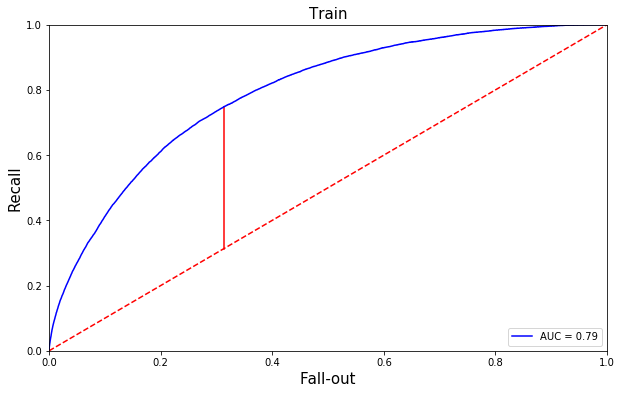

AUC:  0.7902606391705415
KS:  0.43512825704783487


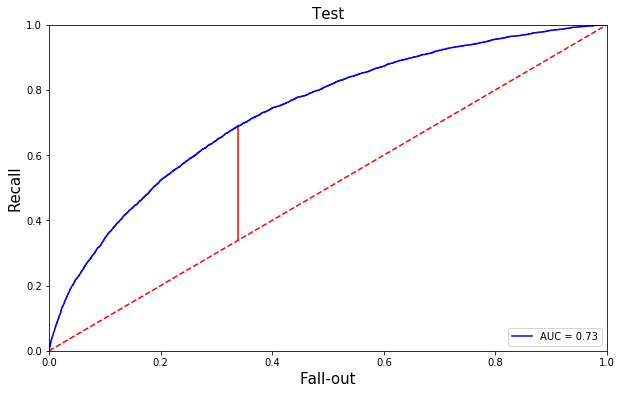

AUC:  0.7348199182676491
KS:  0.3508632769029974


In [10]:
from sklearn.ensemble import RandomForestClassifier

# model training
model = RandomForestClassifier(max_depth=9,n_estimators=100)
model.fit(X_train, y_train)

# output probability
y_hat = model.predict_proba(X_train)[:,1]
y_pred = model.predict_proba(X_test)[:,1]

# evaluation
ev.plot_ROC(y_train, y_hat, 'Train')
ev.plot_ROC(y_test, y_pred, 'Test')